# `Материалы кафедры ММП факультета ВМК МГУ. Введение в глубокое обучение.`

## `Задание 02. Сегментация изображений`

#### Фамилия, имя: 

Дата выдачи: <span style="color:red">__3 марта 19:00__</span>.

Мягкий дедлайн: <span style="color:red">__17 марта 5:00__</span>.

Стоимость: __10 баллов__ (основная часть заданий) + __4.25 балла__ (дополнительные задания).

<span style="color:red">__В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.__</span>

#### `Москва, 2025`

В этом задании вы будете решать задачу сегментации людей на фотографии с помощью нейросетевых архитектур `U-Net` и `LinkNet`. 

Данные для выполнения задания можно скачать по [ссылке](https://disk.yandex.ru/d/tI6d3LBMHTwOnw).

## `Загрузка данных (1 балл)`

Для загрузки данных pytorch опирается на такую сущность, как **`Dataset`**.

Этот абстрактный класс определен в `torch.utils.data.dataset`:

```python
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```
При определении нового источника данных мы создаем наследника данного класса и реализуем методы `__getitem__` и `__len__`.

Пример готового такого класса — `torchvision.datasets.ImageFolder`, который позволяет создать датасет на основе директории с ImageNet-подобной структурой поддиректорий (`./train/{class}` и `./val/{class}`):

```python
imagenet = torchvision.datasets.ImageFolder('path/to/imagenet_root/')
```

Реализуйте класс `PhotosDataset` для выданных данных.

**Внимание.** Возможно, стоит прочитать следующий пункт задания, чтобы реализация была удобной.

In [1]:
import os

import random
import wandb
import numpy as np
import numpy.testing as npt
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg13, VGG13_Weights
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

from PIL import Image, ImageEnhance, ImageDraw

import matplotlib_inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

In [2]:
def set_global_seed(seed: int) -> None:
    """Set global seed for reproducibility.
    :param int seed: Seed to be set
    """
    random.seed(seed)
    np.random.seed(seed)
    
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [3]:
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
wandb_secret = user_secrets.get_secret("wandb") 
wandb.login(key=wandb_secret)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kellesett (kellesett-msu). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
class PhotosDataset(Dataset):
    def __init__(self, images_dir, target_dir=None, transforms=None):
        """
        Arguments
        ---------
        images_dir : str
            Path to directory with images
            
        target_dir : str
            Path to directory with masks.
            Each mask corresponds to one image.
            Corresponding mask and image have the same name, but different format.
            
        transforms : some collection
            Sequence of transformations for images and masks. 
        """
        self.images_dir = images_dir
        self.target_dir = target_dir
        self.imgs = [file for file in sorted(os.listdir(images_dir)) if file[-4:] == '.jpg']
        if target_dir is not None:
            self.masks = [file for file in sorted(os.listdir(target_dir)) if file[-4:] == '.png']
            if len(self.masks) != len(self.imgs):
                raise Exception(f'Dimension missmatch for images({len(self.masks)}) and masks({len(self.imgs)})')
        self.transforms = transforms
        
    def __len__(self):
        return len(self.imgs)
                   
    def __getitem__(self, idx):
        """
        Arguments
        ---------
        idx : int
            Index of image and mask
        
        Returns
        -------
        (image, mask)
        """
        img_path = os.path.join(self.images_dir, self.imgs[idx])
        img = Image.open(img_path)
        if self.target_dir is not None:
            mask_path = os.path.join(self.target_dir, self.masks[idx])
            mask = Image.open(mask_path)
        else:
            mask = img

        if self.transforms is not None:
            for tr in self.transforms:
                if isinstance(tr, transforms.Normalize):
                    img = tr(img)
                else:
                    img, mask = tr(img, mask)
        if self.target_dir is not None:
            return img, mask
        return img

## `Модуль аугментации (2 балла)`

Конструктор стандартного `ImageFolder`, принимает параметр `transform` (и иногда `target_transform`).

Они служат для того, чтобы загружаемые изображения (обычно это `PIL.Image`) или таргеты преобразовывать в тензоры нужного вида.

В `torchvision` входит модуль `transforms` для стандартных примеров таких преобразований. В `transforms` могут содержаться случайные преобразования, это самый простой путь для реализации аугментации данных.

При определении кастомного трансформера помимо конструктора нужно реализовать лишь метод `__call__`:

```python
class HorizontalFlip(object):
    def __init__(self, mode=0):
        self.method = mode

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if self.method:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img

```

С полным списком стандартных преобразований можно ознакомиться в [документации](https://pytorch.org/vision/0.12/transforms.html).

В данной части вам предлагается самостоятельно реализовать несколько кастомных трансформеров.
Обратите внимание, что для некоторых трансформеров, необходимо преобразовывать и изображение, и маску, а для каких-то только изображение.

Один из путей реализации:
* реализовать декоратор, делающий любое преобразование случайным
* реализовать декоратор, применяющий преобразование и к изображению, и к маске

Список трансформеров, которые надо реализовать:

1. случайное (с вероятностью $p$) горизонтальное отображение (flip) изображения 
2. случайное (с вероятностью $p$) вырезание фрагмента изображения (заданного или случайного размера)
3. случайное (с вероятностью $p$) изменение яркости изображения (на заданную или случайную величину)
4. случайное (с вероятностью $p$) изменение фона изображения (на изображение из заданного списка изображений)

Используйте разумные пределы для аугментаций. Одной из причин плохого обучения модели могут быть слишком сильные аугментации. Визуально убедитесь, что граничные случаи достаточно адекватны задаче.

Обратите внимание, что под вырезанием фрагмента подрузумевается вырезания части изображения из исходного, то есть вырезание какой-то части изображения (создание отверстий в изображении). Если после слоя вырезания размеры изображения поменялись, то вы неправильно реализовали модуль.

In [5]:
def random_wrapper(prob):
    def func_wrapper(func):
        def wrapped_func(*args):
            if np.random.binomial(1, prob):
                res = func(*args)
                return res
            else:
                if len(args) > 1:
                    return args
                return args[0]
        return wrapped_func
    return func_wrapper


def masks_wrapper(func):
    def wrapped_func(image, mask, *args):
        image = func(image, *args)
        mask = func(mask, *args)
        return image, mask
    return wrapped_func

In [6]:
class RandomHorizontalFlip:
    def __init__(self, p):
        self.p = p

    def __call__(self, image, mask):
        func = masks_wrapper(self._pil_wrapper)
        func = random_wrapper(self.p)(func)
        image, mask = func(image, mask)
        return image, mask

    @staticmethod
    def _pil_wrapper(image):
        return image.transpose(Image.FLIP_LEFT_RIGHT)


    def __str__(self):
        return f'RandomHorizontalFlip({self.p})'

class EnhanceBrightness:
    def __init__(self, p, value=None, value_range=None):
        self.p = p
        self.value = value
        if value_range is None:
            value_range = (0.75, 1.25)
        self.value_range = value_range

    def __call__(self, image, mask):
        func = random_wrapper(self.p)(self._pil_wrapper)
        image = func(image)
        return image, mask

    def _pil_wrapper(self, image):
        enhancer = ImageEnhance.Brightness(image)
        if self.value is not None:
            value = self.value
        else:
            tmp = self.value_range[1] - self.value_range[0]
            value = np.random.rand() * tmp + self.value_range[0]
        return enhancer.enhance(value)

    def __str__(self):
        return f'EnhanceBrightness({self.p}, {self.value})'
    

class MakeHoles:
    def __init__(self, p, size=None):
        self.p = p
        self.size = size

    def __call__(self, image, mask):
        func = random_wrapper(self.p)(self._pil_wrapper)
        
        if self.size is not None:
            size = self.size
        else:
            size = np.random.rand() * 0.2 * min(image.size[:2])
        center_y = np.random.rand() * image.size[0]
        center_x = np.random.rand() * image.size[1]
        
        image = func(image.copy(), size, center_x, center_y)
        if isinstance(image, tuple):
            image = image[0]
        return image, mask

    def _pil_wrapper(self, image, size, center_x, center_y):
        draw = ImageDraw.Draw(image)
        square_coords = [
            center_x - size,
            center_y - size,
            center_x + size,
            center_y + size,
        ]
        
        draw.rectangle(square_coords, fill=0)
        return image

    def __str__(self):
        return f'MakeHoles({self.p}, {self.size})'
        

class BackgroundChange:
    def __init__(self, p, lst):
        self.p = p
        self.lst = lst

    def __call__(self, image, mask):
        func = random_wrapper(self.p)(self._pil_wrapper)
        image = func(image, mask)[0]
        return image, mask

    def _pil_wrapper(self, image, mask):
        idx = np.random.randint(0, len(self.lst))
        image = Image.composite(image, self.lst[idx], mask)
        return image, mask

    def __str__(self):
        return f'BackgroundChange({self.p}, List of {len(self.lst)} images)'

Добавьте случайные преобразования в ваши датасеты. Также, добавьте преобразование в tensor и нормализацию для изображения:

```python
transforms.ToTensor()
transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
```

In [7]:
set_global_seed(42)
DATA_PATH = '/kaggle/input/task2-data/people_data'

train_dataset = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, 'train'),
    target_dir=os.path.join(DATA_PATH, 'train_mask'),
    transforms=[
        RandomHorizontalFlip(0.5),
        EnhanceBrightness(0.2),
        MakeHoles(0.2),
        masks_wrapper(transforms.ToTensor()),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]
)

test_dataset = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, 'test'),
    target_dir=os.path.join(DATA_PATH, 'test_mask'),
    transforms=[
        masks_wrapper(transforms.ToTensor()),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ]
)

Функция для отображения изображения:

In [8]:
def show_idx_image(dataset, idx):
    image, mask = dataset[idx]

    image = image.permute(1, 2, 0).numpy()
    image = (image * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image = np.clip(image, 0, 1)

    mask = mask.squeeze(0).numpy()

    fig, axes = plt.subplots(1, 2, figsize=(6, 4))

    axes[0].imshow(image)
    axes[1].imshow(mask)
    
    axes[0].set_axis_off()
    axes[1].set_axis_off()
    
    fig.tight_layout()
    plt.show()

Отобразите несколько изображений и масок, на которых будет видна правильная работа вашего модуля аугментации данных. Необходимо проверить каждый модуль аугментации отдельно, в ином случае будут сниматься баллы.

**Важно:** Проверьте корректность работы модулей, действительно ли маска изображения корректна для изображения после аугментации.

---

**Замечание:** значительно удобнее проверить работу каждого модуля независимо от датасета, так как при обращении к его элементу по индексу происходят случайные комбинации преобразований. Также отметим, что аугментация CutOut (реализованный класс MakeHoles) должна быть аналогом Dropout, а значит не менять маску. Логика аналогична Dropout - хотим давать модели возможность выучивать не только всегда хорошо работающие признаки, но и более мелкие детали.


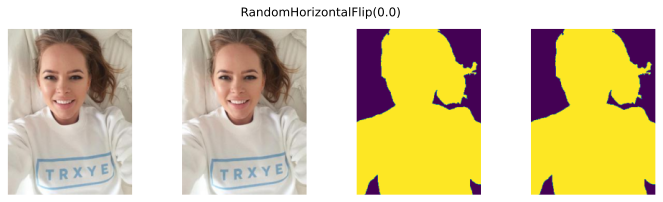

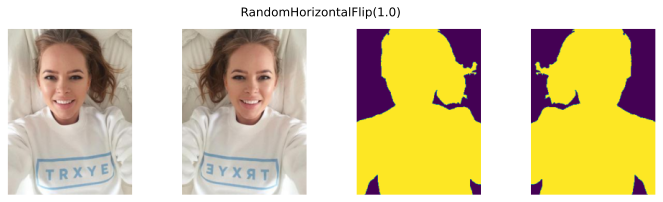

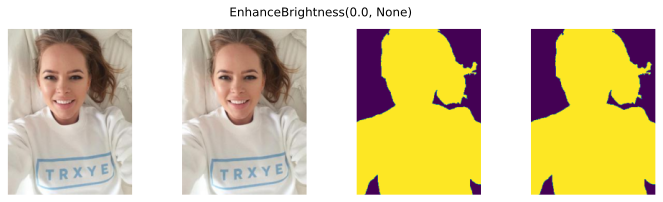

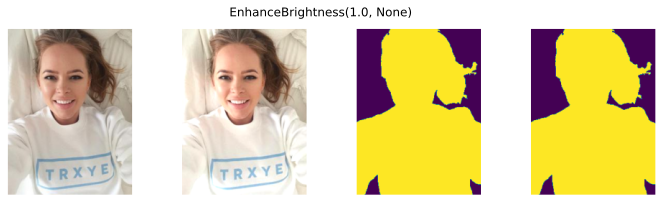

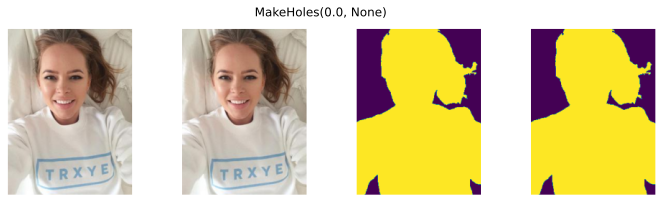

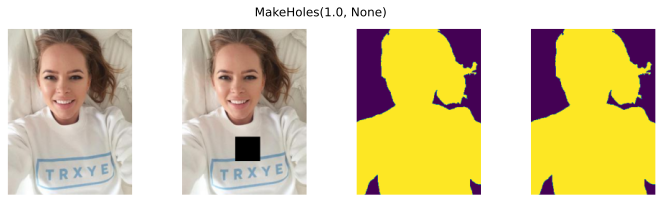

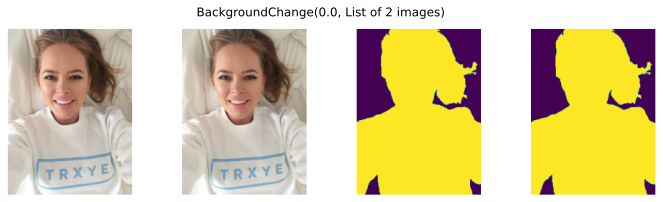

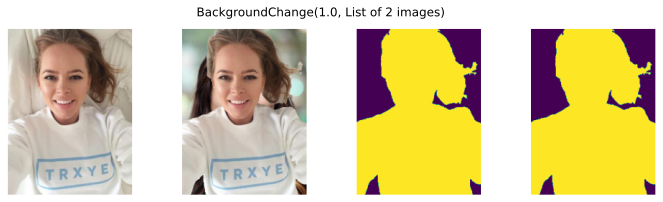

In [9]:
set_global_seed(33)

classes = [RandomHorizontalFlip, EnhanceBrightness, MakeHoles, BackgroundChange]

im3 = Image.open('/kaggle/input/task2-data/people_data/train/2.jpg')
im4 = Image.open('/kaggle/input/task2-data/people_data/train/3.jpg')
lst = [im3, im4]
args = [[], [], [], [lst]]

image = Image.open('/kaggle/input/task2-data/people_data/train/1.jpg')
mask = Image.open('/kaggle/input/task2-data/people_data/train_mask/1.png')

for class_, arg in zip(classes, args):
    for prob in (0., 1.):
        tr = class_(prob, *arg)
        new_image, new_mask = tr(image, mask)
        
        fig, ax = plt.subplots(1, 4, figsize=(12, 3))
        fig.suptitle(str(tr))
        ax[0].imshow(image)
        ax[1].imshow(new_image)
        ax[2].imshow(mask)
        ax[3].imshow(new_mask)
        for i in range(4):
            ax[i].axis(False)
        plt.show()

---

**Замечание:** выведем пару картинок из датасета, чтобы показать корректное применения трансформаций в рамках написанного класса

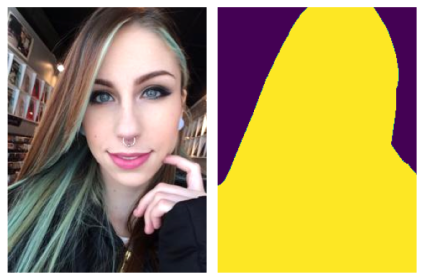

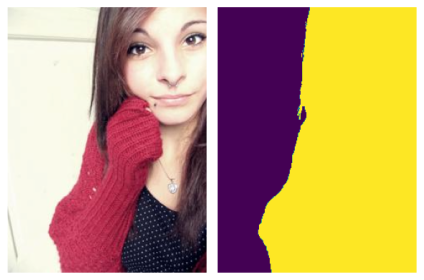

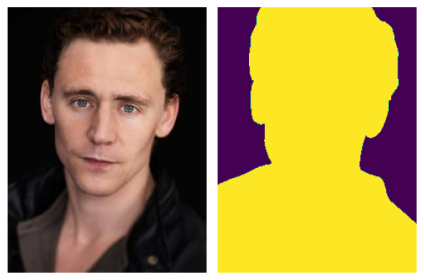

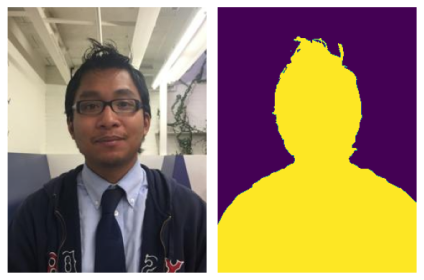

In [10]:
set_global_seed(42)
show_idx_image(train_dataset, 4)
show_idx_image(train_dataset, 52)
show_idx_image(train_dataset, 228)
show_idx_image(train_dataset, 777)

## `Загрузчики`

При обучении сети удобнее работать не с датасетами, а с загрузчиками. Загрузчики создаются на основе датасета и позволяют итерироваться по батчам из него.

Обратите внимание на параметры `DataLoader`. При `num_workers`$\;> 1$, батчи готовятся (загружаются картинки, обрабатываются и так далее) сразу в нескольких фоновых процессах. С помощью параметра `shuffle` можно подавать картинки на обучение в случайном порядке.

Обычно, скорость обработки данных на GPU превышает скорость загрузки данных в одном процессе, поэтому типичное значение для `num_workers`$\approx 3\text{-}10$. 

Учтите, что на некоторых системах в Jupyter Notebook при `num_workers`$>0$ `DataLoader` перестаёт работать. В таком случае установите это значение в $0$.

In [11]:
set_global_seed(42)
test_data_loader = DataLoader(test_dataset, batch_size=8, num_workers=3)
train_data_loader = DataLoader(train_dataset, batch_size=8, num_workers=3, shuffle=True)

In [12]:
for images, masks in train_data_loader:
    print(images.shape, masks.shape)
    break

torch.Size([8, 3, 320, 240]) torch.Size([8, 1, 320, 240])


## `DiceLoss (1 балл)`

Функция потерь реализовывается как и все стандартные нейронные модули в pytorch, через `torch.nn.Module`. В ячейке ниже вам предлагается реализовать функцию потерь `dice` (аналог меры Жаккарда).

Результат **Dice Loss** определим как:

$$
\text{Dice Coefficient} = 2\frac{|A \cap B| }{|A| + |B|} \leadsto \text{Dice Loss} = 1 - \frac{2\sum\limits_{i, j}a_{ij}b_{ij}}{\sum\limits_{ij}(a_{ij} + b_{ij} + \varepsilon)}
$$

где $a_{ij} \in [0, 1]$ — предсказанная вероятность нахождения человека в пикселе изображения, $b_{ij}$ — истинная разметка для пикселя изображения.

In [13]:
class DiceLoss(torch.nn.Module):
    def __init__(self, eps=1e-7, reduction=None, with_logits=True):
        """
        Arguments
        ---------
        eps : float
            eps in denominator
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:
            
            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of elements in the batch
            'sum':  the output will be summed. 
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        self.eps = eps
        self.reduction = reduction
        self.with_logits = with_logits
        
    def forward(self, logits, true_labels):
        """
        Arguments
        ---------
        logits: torch.Tensor
            Unnormalized probability of true class. Shape: [B, ...]
        true_labels: torch.Tensor
            Mask of correct predictions. Shape: [B, ...]
        Returns
        -------
        torch.Tensor
            If reduction is 'mean' or 'sum' returns a tensor with a single element
            Otherwise, returns a tensor of shape [B]
        """
        true_labels = true_labels.to(torch.long)
        
        if self.with_logits:
            logits = torch.sigmoid(logits)
        
        dice_loss = 1 - 2 * (logits * true_labels).sum(axis=(-2, -1)) / (logits + true_labels + self.eps).sum(axis=(-2, -1))
        
        if self.reduction == 'sum':
            # your code here
            loss_value = dice_loss.sum() 
        elif self.reduction == 'mean':
            # your code here
            loss_value = dice_loss.mean()
        elif self.reduction is None:
            # your code here
            loss_value = dice_loss
            
        return loss_value

Проверка реализации:

In [14]:
logits = torch.tensor([
    [[0, 0.5], [0.5, 1]],
    [[0.1, 0.1], [0, 0]],
])

target = torch.tensor([
    [[0, 1], [1, 1]],
    [[1, 0], [0, 1]],
])

losses = DiceLoss(with_logits=False, reduction=None, eps=1e-7)(logits, target)
npt.assert_almost_equal(losses.numpy(), np.array([0.2, 0.90909]), decimal=4)

loss = DiceLoss(with_logits=False, reduction='mean', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 0.554545, decimal=4)

loss = DiceLoss(with_logits=False, reduction='sum', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 1.10909, decimal=4)

## `U-Net (3 балла)`

Для решения задачи сегментации будем использовать [U-Net](https://arxiv.org/pdf/1505.04597.pdf) с энкодером из первых блоков предобученного `VGG13`.

Концептуальная схема представлена на диаграмме ниже:

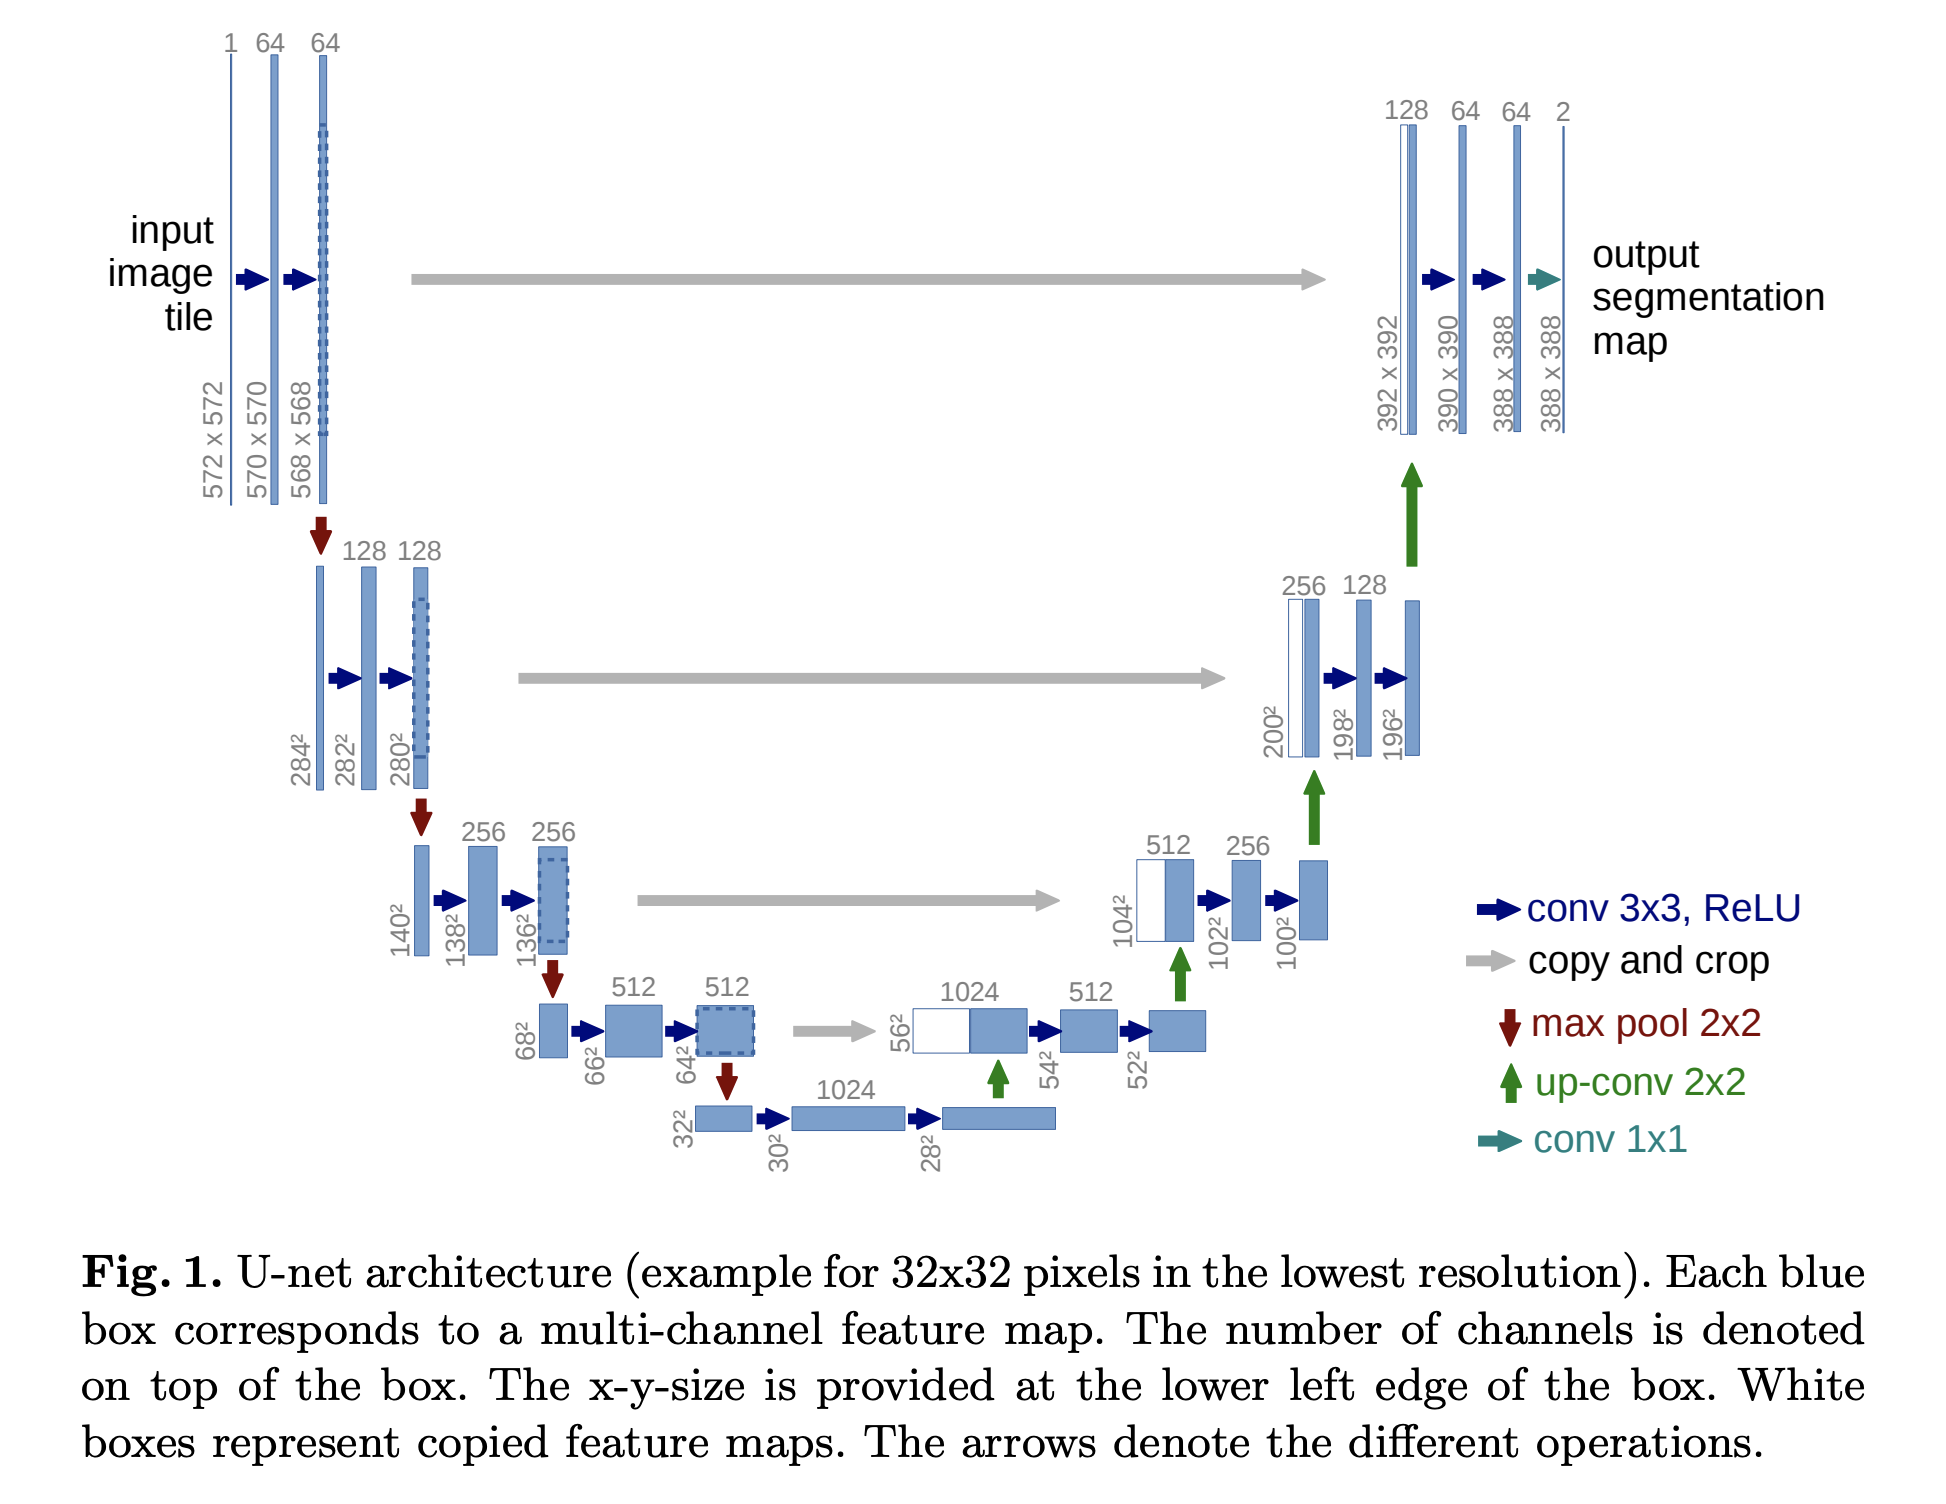

Заметим, что блоки VGG13 имеют следующий вид:
```python
    (0): Conv2d(...)
    (1): ReLU(...)
    (2): Conv2d(...)
    (3): ReLU(...)
    (4): MaxPool2d(...)
```

Для удобства, уберём слои `MaxPool2d` из блоков энкодера и будем применять pooling отдельно. Возможно, вам будет полезно вывести архитектуру модели `VGG` и изучить параметры слоев pooling.

При реализации `Decoder` вам пригодится интерполяция, для этого можно использовать `torch.nn.functional.interpolate` с `mode=nearest`. 

Реализуйте архитектуру данной сети.

#### `Encoder`

In [15]:
feature_extractor = vgg13(weights=VGG13_Weights.DEFAULT).features
summary(feature_extractor, (3, 320, 240), device='cpu')

Downloading: "https://download.pytorch.org/models/vgg13-19584684.pth" to /root/.cache/torch/hub/checkpoints/vgg13-19584684.pth
100%|██████████| 508M/508M [00:02<00:00, 235MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 320, 240]           1,792
              ReLU-2         [-1, 64, 320, 240]               0
            Conv2d-3         [-1, 64, 320, 240]          36,928
              ReLU-4         [-1, 64, 320, 240]               0
         MaxPool2d-5         [-1, 64, 160, 120]               0
            Conv2d-6        [-1, 128, 160, 120]          73,856
              ReLU-7        [-1, 128, 160, 120]               0
            Conv2d-8        [-1, 128, 160, 120]         147,584
              ReLU-9        [-1, 128, 160, 120]               0
        MaxPool2d-10          [-1, 128, 80, 60]               0
           Conv2d-11          [-1, 256, 80, 60]         295,168
             ReLU-12          [-1, 256, 80, 60]               0
           Conv2d-13          [-1, 256, 80, 60]         590,080
             ReLU-14          [-1, 256,

In [16]:
feature_extractor[3]

ReLU(inplace=True)

In [17]:
class VGG13Encoder(torch.nn.Module):
    def __init__(self, num_blocks, weights=VGG13_Weights.DEFAULT):
        super().__init__()
        self.num_blocks = num_blocks
        
        # Будем использовать предобученную VGG13 в качестве backbone
        feature_extractor = vgg13(weights=weights).features
        
        # Каждый блок энкодера U-Net — это блок VGG13 без MaxPool2d
        self.blocks = torch.nn.ModuleList()
        for idx in range(self.num_blocks):
            # Возьмите нужные слои из `feature_extractor` для очередного U-Net блока
            block = []
            for i in range(4):
                if isinstance(feature_extractor[5 * idx + i], torch.nn.ReLU):
                    block.append(torch.nn.ReLU())
                else:
                    block.append(feature_extractor[5 * idx + i])

            # Объедините их с помощью `torch.nn.Sequential`
            block = torch.nn.Sequential(*block)
            self.blocks.append(
                block
            )

    def forward(self, x):
        activations = []
        for idx, block in enumerate(self.blocks):
            # Примените очередной блок U-Net
            # your code here
            x = block(x)

            # Сохраните активации для передачи их в декодер
            # your code here
            activations.append(x)

            # При необходимости примените max-pool
            # Можно использовать `torch.functional.F.max_pool2d`
            # your code here
            if idx != self.num_blocks - 1:
                x = torch.functional.F.max_pool2d(
                    x,
                    kernel_size=2,
                    stride=2,
                    padding=0,
                    dilation=1,
                    ceil_mode=False
                )
            
        return activations

In [18]:
assert sum((param.numel() for param in VGG13Encoder(num_blocks=1).parameters())) == 38720
assert sum((param.numel() for param in VGG13Encoder(num_blocks=2).parameters())) == 260160
assert sum((param.numel() for param in VGG13Encoder(num_blocks=3).parameters())) == 1145408

x = torch.arange(1 * 3 * 320 * 240).reshape(1, 3, 320, 240) / (1 * 3 * 320 * 240)
out = VGG13Encoder(num_blocks=3)(x)

assert len(out) == 3
npt.assert_almost_equal(torch.linalg.norm(out[0]).item(), 902.218, decimal=3)
npt.assert_almost_equal(torch.linalg.norm(out[1]).item(), 571.030, decimal=3)
npt.assert_almost_equal(torch.linalg.norm(out[2]).item(), 648.068, decimal=3)

#### `Decoder`

In [19]:
class DecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.ConvTranspose2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3,  padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = torch.nn.ReLU()
        
    def forward(self, down, left):
        # Upsample x2 и свёртка
        # your code here
        x = torch.nn.functional.interpolate(down, scale_factor=2, mode='nearest')
        x = self.upconv(x)        
        
        # Конкатенация выхода энкодера и предыдущего блока декодера
        # your code here
        x = torch.cat((left, x), dim=1)
        
        # Две свёртки с ReLu
        # your code here
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.relu(x)
        
        return x

In [20]:
class Decoder(torch.nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        self.blocks = torch.nn.ModuleList()
        for idx in range(num_blocks):
            self.blocks.insert(0, DecoderBlock(num_filters * 2 ** idx))

    def forward(self, acts):
        up = acts[-1]
        for block, left in zip(self.blocks, acts[-2::-1]):
            up = block(up, left)
        return up

In [21]:
class UNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_blocks=4):
        super().__init__()
        # your code here
        self.encoder = VGG13Encoder(num_blocks)
        
        # your code here
        self.decoder = Decoder(64, num_blocks - 1)
        
        # Свёртка 1x1 для попиксельной агрегации каналов
        # your code here
        self.final = torch.nn.Conv2d(
            in_channels=64,
            out_channels=1,
            kernel_size=1,
            padding=0,
            dilation=1
        )

    def forward(self, x):
        # your code here
        activations = self.encoder(x)
        x = self.decoder(activations)
        x = self.final(x)
        return x

In [22]:
model = UNet(num_classes=1, num_blocks=3)
x = torch.arange(1 * 3 * 320 * 240).reshape(1, 3, 320, 240) / (1 * 3 * 320 * 240)

assert sum((param.numel() for param in model.parameters())) == 2067649
assert list(model(x).shape) == [1, 1, 320, 240]

### `Оценивание качества сети`


Обычно, оптимизируемый функционал сложно интерпретировать, а так же в разных экспериментах могут использоваться разные функции потерь. Поэтому необходимо замерять и отслеживать независимую метрику качества. Предлагается использовать **IoU (Intersection over Union)** — один из стандартных вариантов для задачи сегментации:
$$
\text{IoU} = \frac{|A \cap B|}{|A \cup B|} = \frac{\sum\limits_{ij}a_{ij}b_{ij}}{\sum\limits_{ij}a_{ij} + b_{ij} - a_{ij}b_{ij}}
$$

Учтите, что знаменатель может быть равен нулю, например, если маска нулевая. Такие объекты можно не учитывать при агрегации и пропускать, так как в ином случае подсчет метрики на всем батче будет NaN. В pytorch есть встроенные для этого функции с префиксом nan.


In [23]:
class IoUScore(torch.nn.Module):
    def __init__(self, threshold, reduction=None, with_logits=False):
        """
        Arguments
        ---------
        threshold : float
            threshold for logits binarization
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:
            
            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of elements in the batch
            'sum':  the output will be summed. 
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        
        self.threshold = threshold
        self.reduction = reduction
        self.with_logits = with_logits
        
    @torch.no_grad()
    def forward(self, logits, true_labels):
        """
        Arguments
        ---------
        logits: torch.Tensor
            Unnormalized probability of true class. Shape: [B, ...]
        true_labels: torch.Tensor
            Mask of correct predictions. Shape: [B, ...]
        Returns
        -------
        torch.Tensor
            If reduction is 'mean' or 'sum' returns a tensor with a single element
            Otherwise, returns a tensor of shape [B]
        """
        # your code here
        if self.with_logits:
            logits = torch.sigmoid(logits)
            
        pred_labels = torch.where(logits > self.threshold, 1., 0.)
        tmp = (pred_labels * true_labels).sum(axis=(-2, -1))
        score = tmp / ((pred_labels + true_labels).sum(axis=(-2, -1)) - tmp)
        
        if self.reduction == 'sum':
            # your code here
            score = score.nansum()
        elif self.reduction == 'mean':
            # your code here
            score = score.nanmean() 
            
        return score

In [24]:
logits = torch.tensor([
    [
        [0.3089,  0.4311, -0.9711],
        [0.9030,  1.0325, -0.7607],
        [0.9648, -0.5528, -1.1010]
    ], [
        [0.8906,  0.8099,  0.4458],
        [2.6215, -1.3198,  0.3142],
        [0.2262, -0.9175, -0.0174]
    ], [
        [0.8906,  0.8099,  0.4458],
        [2.6215, -1.3198,  0.3142],
        [0.2262, -0.9175, -0.0174]
    ]
])
true_labels = torch.tensor([
    [
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.]
    ], [
        [1., 1., 1.],
        [1., 0., 1.],
        [1., 0., 0.]
    ], [
        [1., 1., 1.],
        [0., 1., 1.],
        [1., 1., 1.]
    ]
])

scores = IoUScore(0.0)(logits, true_labels)
npt.assert_almost_equal(scores.numpy(), np.array([0.3333, 1.0000, 0.5556]), decimal=4)

score = IoUScore(0.0, reduction='sum')(logits, true_labels)
npt.assert_almost_equal(score.item(), 1.8889, decimal=4)

score = IoUScore(0.0, reduction='mean')(logits, true_labels)
npt.assert_almost_equal(score.item(), 0.6296, decimal=4)

### `Логирование`

При реализации цикла обучения необходимо сохранять метрики $1\text{-}9$ с использованием модуля [torch.utils.tensorboard](https://pytorch.org/docs/stable/tensorboard.html) или с помощью модуля [wandb](https://docs.wandb.ai/tutorials/) вам предлагается самим выбрать более удобный для вас модуль.

Для отслеживания процесса обучения обычно требуется сохранять информацию разных его аспектах.

Для полного контроля над процессом обучения обычно требуется сохранять информацию о разных статистиках. Самыми очевидными являются:
1. Значение функции потерь (лосса) на обучающей и тестовой выборках
2. Метики качества, например, **Dice Coefficient** и **IoU (Intersection over Union)** на обучающей и тестовой выборках

Однако, суррогатные метрики могут не отражать реального качества. Поэтому для моделей, которые выдают визуализируемый результат, обычно логируют предсказания для некоторых объектов выборки. В задаче сегментации естественным вариантом является логирование четвёрки: исходное изображение, истинная маска, маска вероятностей истинного класса, бинаризованная маска. 

*Замечание:* лосс и качество на обучающей выборке обычно логируют не только в конце каждой эпохи, но и по отдельным батчам на каждой итерации.

3. Чтобы отслеживать динамику обучения необходимо зафиксировать небольшой набор объектов обучающей и тестовой выборок и после каждой эпохи обучения логировать указанные четыре картинки для каждого объекта.

*Замечание:* можно логировать четвёрки изображений независимо, однако, удобнее объединить их на одной фигуре [реализация через Tensorboard](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_figure), [реализация через Wandb](https://docs.wandb.ai/guides/track/log/plots/#matplotlib-and-plotly-plots) (лучше делать через fig и Image). Дополнительный плюс — возможность подписать значения метрик для этого объекта в заголовке изображения или добавить colorbar для более простой интерпретации предсказанной маски.

Для удобной категоризации экспериментов обычно в начале обучения сохраняют:

4. Гиперпараметры модели [реализация через Tensorboard](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_hparams), [реализация через Wandb](https://docs.wandb.ai/guides/track/config/)
5. Структуру модели [реализация через Tensorboard](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_graph), **про реализацию wandb ниже**

Для исследования технических особенностей обучения полезно логировать следующие статистики:

6. Распределение весов, активаций, градиентов [реализация через Tensorboard](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_histogram), [реализация через Wandb](https://docs.wandb.ai/ref/python/data-types/histogram/). Сохранять гистограммы каждого параметра после каждой итерации может быть вычислительно неэффективно, поэтому обычно сохраняют распределения весов для каждого отдельного слоя нейронной сети после каждой эпохи. 
7. Норма весов и норма градиента на каждой итерации

Наконец, после каждой эпохи можно визуализировать промежуточные представления входных данных:

8. Активации после каждого слоя/блока, как изображения
9. Градиенты функции потерь по активациям для некоторых объектов обучающей выборки, как изображения

*Замечание:* для реализации пунктов 8, 9 менять код модели не требуется. Используйте хуки: [register_full_backward_hook](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook) (данный хук не работает с inplace операциями, например, с `torch.nn.ReLU(inplace=True)`. Или не используйте inplace операции, или используйте [`Tensor.register_hook`](https://github.com/pytorch/pytorch/issues/61519)), [register_forward_hook](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_forward_hook).

Файлы с логами, а также чекпоинты весов модели после итерации с наилучшим валидационным качеством (смотрите [torch.save](https://pytorch.org/docs/stable/generated/torch.save.html) и [torch.nn.Module.state_dict](https://pytorch.org/tutorials/recipes/recipes/what_is_state_dict.html)) для **ВСЕХ** проведённых экспериментов (за исключением упавших, недосчитанных и так далее) необходимо сдать в anytask.

#### `Некоторые советы по wandb`

- При логировании всегда указывайте параметр step, который должен не уменьшаться.

- При логировании изображений лучше их нормировать в диапазон [0, 1] как в функции `show_idx_image` выше. Для логирования предсказаний маски, лучше использовать вероятности. При неправильном диапозоне изображения могут отображаться неверно!

- Вместо логирования изображений, лучше логировать `matplotlib` графики и соответсвующие им `figure`. Кроме того, лучше закрывать все открытые графики, чтобы не перегружать ноутбук. Пример кода:


```python
fig, ax = plt.subplots(...)
...
wandb.log({key: wandb.Image(fig)}, step=global_step)
plt.close('all')
```

- Функционал построение bins в `wandb.Histogram` ограничен, можете посмотреть в сторону аргумента `np_histogram`.

- Wandb не имеет широкого функционала для логирования структуры модели. Есть способ через wandb.watch(net, log_graph=True), но получаемый результаты сильно отличаются от возможностей `tensorboard`. К счастью, `wandb` умеет синхронизировать логи с `Tensorboard` поэтому можно использовать следующую логику:


```python
wandb.init(
    project=project_name, 
    name=run_name, 
    config=config, 
    sync_tensorboard=True        # Синхронизация с tensorboard
)

writer = SummaryWriter(run_name) # Создание логера tensorboard

# Логирование графа модели
writer.add_graph(net, input_x)
writer.close()

train_loop(...)
wandb.finish()
```

- `wandb` по умолчанию сохраняет все логи локально и на сайте в вашем личном хранилище. В случае перезагрузки `Google Colab` локальные файлы не сохраняются! Кроме того, скачивание файлов не через GoogleDisk достаточно продолжительное (в районе 20-30 минут).

- В `wandb` можно легко сохранять код и указать директорию, так вы никогда не забудете какой именн/о код получает результаты логов.

```python
wandb.init(..., settings=wandb.Settings(code_dir="."))
```

Кроме того, можно сохранить отдельные файлы:

```python
wandb.init(..., save_code=True)
wandb.run.log_code(
    "./", 
    include_fn=lambda path: condition(path)
)
```

- В `wandb` есть функция для автоматического логирования весов и градиентов модели `wandb.watch()`, но функционал слишком ограничен и накладывает слишком много накладных расходов. **Лучше писать руками!**

#### `Некоторые советы по tensorboard`

- Функционал и возможности `tensorboard` шире (работа с 3D, продвинутые визуализации).

- `tensorboard` сохраняет логи только локально, то есть после закрытия `Google Colab` ничего не сохранится. В реальных проектах это является сильной стороной, так как гарантирует безопасность и конфиденциальность.

- Для визуализации логов достаточно запустить в ноутбуке или в терминале соответсвующее расширение, однако в случае `Google Colab` для этого приходится прокидывать порты, [подробнее тут](https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab).

- `tensorboard` меньше лагает и более легковесный.


### `Некоторые советы по логированию`

- Вы можете выбрать либо `wandb`, либо `tensorboard`.

- В реальных проектах лучше добавить логирование кода с целью сохранения и воспроизводимости результатов.

- Называйте запуски осмысленно, чтобы по названию можно было понять смысл запуска и варьеруемые параметры.


### `Эксперименты`

Теперь применим сеть на практике!

Обучите сеть на обучающей выборке и протестируйте качество на тестовой выборке. 

Сначала при обучении используйте только кросс-энтропию (`torch.nn.BCEWithLogitsLoss` будет более удобна для бинарного случая). Зафиксируйте результат.

Сравните между собой несколько стратегий оптимизации:
1. Только кросс-энтропия
2. Только dice loss
3. Сумма двух лоссов с весами (попробуйте $3\text{-} 4$ разных соотношения)

**Для всех экспериментов отобразите графики функции потерь и качества за время обучения. Выведите получившиеся маски для нескольких изображений из датасета. Сделайте выводы.**

In [25]:
class OptimizerWrapper:
    def __init__(self, optimizer, loss_fn):
        """
        :optimizer - базовый оптимизатор
        :loss_fn - функция по батчу вычисляющая loss и другие важные в ходе обучения значения.
        Функция возвращает словарь, в котором обязательно присутсвует ключ 'loss'.
        Значение функции потерь храняться по ключу 'loss'
        
        """
        self.optimizer = optimizer
        self.loss_fn = loss_fn
    
    def get_param_groups(self):
        """
        return
        Ссылку на параметры модели, т.е. изменение значения, меняет значение внутри модели
        
        Замечание: захардкожено [0]
        """
        return self.optimizer.param_groups[0]['params']
    
    def get_group(self):
        """
        return
        Возвращает группу параметров оптимизатора
        
        Замечание: захардкожено [0]
        """
        return self.optimizer.param_groups[0]
    
    def zero_grad(self):
        """
        Обнуляет все градиенты для параметров оптимизатора
        """
        self.optimizer.zero_grad()
        
    def step(self):
        """
        Производит шаг оптимизатора
        """
        self.optimizer.step()
        
    def step_fn(self, batch):
        """ 
        Считает все статистики на батче, производит шаг оптимизации
        return
        Все необходимые статистики для логирования
        """
        self.zero_grad()
        stat_dict = self.loss_fn(batch)
        loss = stat_dict['loss']
        loss.backward()
        self.step()
        return stat_dict

In [26]:
class WandbTrainer:
    def __init__(
        self,
        model,
        optimizer,
        device,
        criterion_fn,
        train_dataloader,
        valid_dataloader,
        train_subset,
        valid_subset,
        project,
        config,
    ):
        self.model = model
        self.device = device
        self.criterion_fn = criterion_fn
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader

        self._available_subsets = {
            'train': train_subset,
            'eval': valid_subset
        }
        self.global_step = None
        self.project = project
        self.config = config
        
        self.loss_fn = self.loss_fn_constructor()
        self.optimizer_wrapper = OptimizerWrapper(optimizer, self.loss_fn)

    @torch.no_grad()
    def log_visualization(self, subset, threshold=0.5):
        device = self.device
        self.model.eval()

        iou_fn = IoUScore(threshold=threshold, reduction=None, with_logits=False)
        
        if subset not in self._available_subsets.keys():
            raise Exception(f'Available subsets for visualization: {self._available_subsets.keys()} [not from {subset}]')
        images, masks = self._available_subsets[subset]
        images, masks = images.to(device), masks.to(device)

        probs = torch.sigmoid(self.model(images))
        iou_scores = iou_fn(probs, masks)
        
        images, masks, probs = images.detach().cpu(), masks.detach().cpu(), probs.detach().cpu()

        fig, ax = plt.subplots(len(images), 4, figsize=(8, 8))
        for i in range(len(images)):
            image = images[i]
            mask = masks[i]
            prob = probs[i]

            if i == 0:
                ax[i, 0].set_title(f'original image\n')
                ax[i, 1].set_title(f'true mask\n')
                ax[i, 2].set_title(f'predicted mask\n')
                ax[i, 3].set_title(f'bin. pred. mask\nIoU score: {float(iou_scores[i]):.3f}')
            else:
                ax[i, 3].set_title(f'IoU score: {float(iou_scores[i]):.3f}')
                
            show_torch_image(image, ax[i, 0], norm=True)
            show_torch_image(mask, ax[i, 1])
        
            prob_im = show_torch_image(prob, ax[i, 2], clip=False)
            divider = make_axes_locatable(ax[i, 2])
            cax = divider.append_axes('right', size='10%', pad=0.05)
            fig.colorbar(prob_im, cax=cax, orientation='vertical')
            
            show_torch_image(torch.where(prob > threshold, 1., 0.), ax[i, 3])
        plt.tight_layout()
        
        wandb.log({f'{subset}/visualization': wandb.Image(fig)}, step=self.global_step)
        plt.close('all')

    @torch.no_grad()
    def log_distributions(self):
        for tag, value in self.model.named_parameters():
            g = value.grad
            if g is None:
                continue

            hist = np.histogram(g.data.cpu())
            wandb.log({f"grad_dist/{tag}": wandb.Histogram(np_histogram=hist)}, self.global_step)
            hist = np.histogram(value.data.cpu())
            wandb.log({f"params_dist/{tag}": wandb.Histogram(np_histogram=hist)}, self.global_step)
                
    @torch.no_grad()
    def log_norm(self):
        for tag, value in self.model.named_parameters():
            g = value.grad
            if g is None:
                continue
            
            wandb.log({f"grad_norm/{tag}": torch.norm(g.cpu())}, self.global_step)
            wandb.log({f"params_norm/{tag}": torch.norm(value.data.cpu())}, self.global_step)
    
    def log_activations(self):
        device = self.device
        
        self.activations = []
        self.grads = []
        hooks = []
        for tag, module in self.model.named_modules():
            if isinstance(module, torch.nn.ReLU):
                activation_hook = module.register_forward_hook(self.activations_hook)
                grad_hook = module.register_full_backward_hook(self.grads_hook)
                hooks.extend([activation_hook, grad_hook])

        subset = self._available_subsets['train']
        image, mask = subset[0][0:1].to(device), subset[1][0:1].to(device)
        stat_dict = self.loss_fn((image, mask))
        loss = stat_dict['loss']
        self.model.zero_grad()
        loss.backward()
                
        for layer, activation in enumerate(self.activations):
            fig, ax = plt.subplots(3, 3)
            for i in range(3):
                for j in range(3):
                    idx = 3 * i + j
                    show_torch_image(activation[0, idx, :, :][None, :, :], ax[i][j])
            plt.tight_layout()
            wandb.log({f'activations/layer_{layer}': wandb.Image(fig)}, step=self.global_step)
            plt.close('all')

        for layer, grad in enumerate(self.grads[::-1]):
            fig, ax = plt.subplots(3, 3)
            for i in range(3):
                for j in range(3):
                    idx = 3 * i + j
                    show_torch_image(grad[0, idx, :, :][None, :, :], ax[i][j])
            plt.tight_layout()
            wandb.log({f'grads/layer_{layer}': wandb.Image(fig)}, step=self.global_step)
            plt.close('all')

        for hook in hooks:
            hook.remove()
    
    def activations_hook(self, module, input, output):
        self.activations.append(output.detach().data.cpu())

    def grads_hook(self, module, grad_input, grad_output):
        self.grads.append(grad_input[0].detach().data.cpu())
    
    @torch.no_grad()
    def evaluate(self):
        device = self.device
        self.model.eval()
        
        loss, dice_loss, iou_score = 0, 0, 0
        count = 0
        
        for batch in self.valid_dataloader:
            stat_dict = self.loss_fn(batch)

            bs = batch[0].shape[0]
            loss += stat_dict['loss'].item() * bs
            dice_loss += stat_dict['dice_loss'].item() * bs
            iou_score += stat_dict['iou_score'].item() * bs
            count += bs
            
        return loss / count, dice_loss / count, iou_score / count

    def train(self, epoch_num, name='default', eval_interval=50):
        device = self.device
        wandb.init(
            project=self.project,
            name=name,
            config=self.config,
            settings=wandb.Settings(quiet=True),
        )
        wandb.watch(self.model, log_graph=True)
        
        self.global_step = 1
        self.best_iou = 0.
        self.model = self.model.to(device)
        
        for i in tqdm(range(epoch_num)):
            self.model.train()
            for batch in self.train_dataloader:          
                d = self.optimizer_wrapper.step_fn(batch)
                loss = d['loss']
                dice_loss = d['dice_loss']
                iou_score = d['iou_score']
                
                wandb.log({
                    "train/loss": loss.item(),
                    "train/Dice_Loss": dice_loss.item(),
                    'train/IoU_Score': iou_score.item()
                }, step=self.global_step)
                
                if self.global_step % eval_interval == 0:
                    loss, dice_loss, iou_score = self.evaluate()

                    if iou_score > self.best_iou:
                        self.best_iou = iou_score
                        torch.save(self.model.state_dict(), f'/kaggle/working/{name}')
                    self.model.train()
                    
                    wandb.log({
                        "eval/loss": loss,
                        "eval/Dice_Loss": dice_loss,
                        'eval/IoU_Score': iou_score
                    }, step=self.global_step)
                    
                self.log_norm()
                
                self.global_step += 1

            self.log_distributions()
            self.log_activations()
            self.log_visualization('train')
            self.log_visualization('eval')
            
        wandb.finish()

    def loss_fn_constructor(self):
        device = self.device
        
        dice_fn = DiceLoss(reduction='mean', with_logits=True)
        iou_fn = IoUScore(threshold=0.5, reduction='mean', with_logits=True)
        
        def loss_fn(batch):
            images, masks = batch
            images, masks = images.to(device), masks.to(device)
                
            y_pred = self.model(images)
            loss = self.criterion_fn(y_pred, masks)
            
            dice_loss = dice_fn(y_pred, masks)
            iou_score = iou_fn(y_pred, masks)
    
            weights = []
            grads = []
            state_dict = {
                'loss': loss,
                'dice_loss': dice_loss,
                'iou_score': iou_score,
            }
            return state_dict
        
        return loss_fn

In [27]:
def show_torch_image(image, ax, norm=False, clip=True):
    image = image.permute(1, 2, 0).numpy()
    if norm:
        image = (image * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    if clip:
        image = np.clip(image, 0, 1)
    ax.imshow(image)
    ax.set_axis_off()

In [28]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cuda'

In [29]:
class CombinedLoss(torch.nn.Module):
    def __init__(self, losses, coefs, reduction):
        super().__init__()
        self.losses = losses
        self.coefs = coefs
        self.reduction = reduction

    def forward(self, logits, true_labels):
        """
        Arguments
        ---------
        logits: torch.Tensor
            Unnormalized probability of true class. Shape: [B, ...]
        true_labels: torch.Tensor
            Mask of correct predictions. Shape: [B, ...]
        Returns
        -------
        torch.Tensor
            If reduction is 'mean' or 'sum' returns a tensor with a single element
            Otherwise, returns a tensor of shape [B]
        """
        true_labels = true_labels.to(torch.float)
        
        loss_value = 0.
        for loss_fn, coef in zip(self.losses, self.coefs):
            current_loss = loss_fn(logits, true_labels)
            loss_value += current_loss * coef
            
        if self.reduction == 'sum':
            # your code here
            loss_value = loss_value.sum() 
        elif self.reduction == 'mean':
            loss_value = loss_value.mean()
            
        return loss_value

In [30]:
set_global_seed(42)

pairs = [train_dataset[i] for i in range(4)]
set_train = (torch.stack([pairs[i][0] for i in range(4)]), torch.stack([pairs[i][1] for i in range(4)]))
pairs = [test_dataset[i] for i in range(4)]
set_test = (torch.stack([pairs[i][0] for i in range(4)]), torch.stack([pairs[i][1] for i in range(4)]))

In [31]:
dice_loss = DiceLoss(reduction='mean', with_logits=True)
bce_loss = torch.nn.BCEWithLogitsLoss(reduction='mean') 

In [32]:
set_global_seed(42)

model = UNet(num_classes=1, num_blocks=3).to(device)
config = {
    'num_blocks': 3,
    'loss': [bce_loss, dice_loss],
    'loss_coefs': [1., 0.],
    'optimizer': torch.optim.Adam(params=model.parameters(), lr=3e-4),
}

criterion_fn = CombinedLoss(config['loss'], config['loss_coefs'], reduction='mean')
optimizer = config['optimizer']

trainer = WandbTrainer(
    model,
    optimizer,
    device,
    criterion_fn,
    train_data_loader,
    test_data_loader,
    set_train,
    set_test,
    'CNN-workshop',
    config,
)

trainer.train(15, 'UNet-BCE', 100)

wandb: Syncing run UNet-BCE
wandb: 🚀 View run at https://wandb.ai/kellesett-msu/CNN-workshop/runs/ktj68l0i
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
100%|██████████| 15/15 [11:05<00:00, 44.38s/it]
wandb:                                                                                
wandb: 🚀 View run UNet-BCE at: https://wandb.ai/kellesett-msu/CNN-workshop/runs/ktj68l0i
wandb: ⭐️ View project at: https://wandb.ai/kellesett-msu/CNN-workshop
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 271 other file(s)


In [33]:
set_global_seed(42)

model = UNet(num_classes=1, num_blocks=3).to(device)
config = {
    'num_blocks': 3,
    'loss': [bce_loss, dice_loss],
    'loss_coefs': [0., 1.],
    'optimizer': torch.optim.Adam(params=model.parameters(), lr=3e-4),
}

criterion_fn = CombinedLoss(config['loss'], config['loss_coefs'], reduction='mean')
optimizer = config['optimizer']

trainer = WandbTrainer(
    model,
    optimizer,
    device,
    criterion_fn,
    train_data_loader,
    test_data_loader,
    set_train,
    set_test,
    'CNN-workshop',
    config,
)

trainer.train(15, 'UNet-Dice', 100)

wandb: Syncing run UNet-Dice
wandb: 🚀 View run at https://wandb.ai/kellesett-msu/CNN-workshop/runs/23yfh4j3
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
100%|██████████| 15/15 [11:10<00:00, 44.71s/it]
wandb: uploading media/images/eval/visualization_2536_89c4710b7b32e47165a6.png; uploading wandb-summary.json; uploading config.yaml; uploading output.log
wandb:                                                                                
wandb: 🚀 View run UNet-Dice at: https://wandb.ai/kellesett-msu/CNN-workshop/runs/23yfh4j3
wandb: ⭐️ View project at: https://wandb.ai/kellesett-msu/CNN-workshop
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 271 other file(s)


In [34]:
ratio_grid = [(0.25, 0.75), (0.5, 0.5), (0.75, 0.25)]

for ratio in ratio_grid:
    set_global_seed(42)

    model = UNet(num_classes=1, num_blocks=3).to(device)
    config = {
        'num_blocks': 3,
        'loss': [bce_loss, dice_loss],
        'loss_coefs': ratio,
        'optimizer': torch.optim.Adam(params=model.parameters(), lr=3e-4),
    }
    criterion_fn = CombinedLoss(config['loss'], config['loss_coefs'], reduction='mean')
    optimizer = config['optimizer']
    
    trainer = WandbTrainer(
        model,
        optimizer,
        device,
        criterion_fn,
        train_data_loader,
        test_data_loader,
        set_train,
        set_test,
        'CNN-workshop',
        config,
    )
    
    trainer.train(15, f'UNet-Mixed[{ratio[0]}:{ratio[1]}]', 100)

wandb: Syncing run UNet-Mixed[0.25:0.75]
wandb: 🚀 View run at https://wandb.ai/kellesett-msu/CNN-workshop/runs/34xbolsu
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
100%|██████████| 15/15 [11:12<00:00, 44.84s/it]
wandb:                                                                                
wandb: 🚀 View run UNet-Mixed[0.25:0.75] at: https://wandb.ai/kellesett-msu/CNN-workshop/runs/34xbolsu
wandb: ⭐️ View project at: https://wandb.ai/kellesett-msu/CNN-workshop
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 271 other file(s)
wandb: Syncing run UNet-Mixed[0.5:0.5]
wandb: 🚀 View run at https://wandb.ai/kellesett-msu/CNN-workshop/runs/2jvlkouo
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
100%|██████████| 15/15 [11:11<00:00, 44.77s/it]
wandb:                                                                                
wandb: 🚀 View run UNet-Mixed[0.5:0.5] at: https://wandb.ai/kellesett-msu/CNN-workshop/runs/2jvlk

---

**Замечание:** Все выводы, а также визуализации можно найти в прикрепленном отчете

## `LinkNet (2 балла)`

Реализуйте архитектуру [LinkNet](https://arxiv.org/pdf/1707.03718.pdf) с использованием энкодера, основанного на `VGG13`. Архитектура похожа на `Unet`, но вместо конкатенации слоёв используются skip-connections (сложения). Для реализации достаточно переписать структуру декодировщика из предыдущего пункта.

*Подсказка:* так как конкатенации слоёв заменили на skip-connections, то ожидается, что число параметров стало меньше.

**Обучите сеть и проведите анализ согласно предыдущему пункту. Сравните LinkNet и U-Net по качеству и скорости работы. Сделайте выводы.**

In [35]:
class LinkNetDecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.ConvTranspose2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3,  padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = torch.nn.ReLU()
        
    def forward(self, down, left):
        # Upsample x2 и свёртка
        # your code here
        x = torch.nn.functional.interpolate(down, scale_factor=2, mode='nearest')
        x = self.upconv(x)        
        
        # skip connection
        # your code here
        x = x + left
        
        # Две свёртки с ReLu
        # your code here
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.relu(x)
        
        return x


class LinkNetDecoder(torch.nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        self.blocks = torch.nn.ModuleList()
        for idx in range(num_blocks):
            self.blocks.insert(0, LinkNetDecoderBlock(num_filters * 2 ** idx))

    def forward(self, acts):
        up = acts[-1]
        for block, left in zip(self.blocks, acts[-2::-1]):
            up = block(up, left)
        return up

class LinkNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_blocks=4):
        super().__init__()
        # your code here
        self.encoder = VGG13Encoder(num_blocks)
        
        # your code here
        self.decoder = LinkNetDecoder(64, num_blocks - 1)
        
        # Свёртка 1x1 для попиксельной агрегации каналов
        # your code here
        self.final = torch.nn.Conv2d(
            in_channels=64,
            out_channels=1,
            kernel_size=1,
            padding=0,
            dilation=1
        )

    def forward(self, x):
        # your code here
        activations = self.encoder(x)
        x = self.decoder(activations)
        x = self.final(x)
        return x

Проведем тесты, учитывая подсказку:

In [36]:
model = LinkNet(num_classes=1, num_blocks=3)
x = torch.arange(1 * 3 * 320 * 240).reshape(1, 3, 320, 240) / (1 * 3 * 320 * 240)

assert sum((param.numel() for param in model.parameters())) < 2067649
assert list(model(x).shape) == [1, 1, 320, 240]

In [37]:
set_global_seed(42)

model = LinkNet(num_classes=1, num_blocks=3).to(device)
config = {
    'num_blocks': 3,
    'loss': [bce_loss, dice_loss],
    'loss_coefs': [1., 0.],
    'optimizer': torch.optim.Adam(params=model.parameters(), lr=3e-4),
}

criterion_fn = CombinedLoss(config['loss'], config['loss_coefs'], reduction='mean')
optimizer = config['optimizer']

trainer = WandbTrainer(
    model,
    optimizer,
    device,
    criterion_fn,
    train_data_loader,
    test_data_loader,
    set_train,
    set_test,
    'CNN-workshop',
    config,
)

trainer.train(15, 'LinkNet-BCE', 100)

wandb: Syncing run LinkNet-BCE
wandb: 🚀 View run at https://wandb.ai/kellesett-msu/CNN-workshop/runs/fhbzox5v
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
100%|██████████| 15/15 [10:42<00:00, 42.82s/it]
wandb:                                                                                
wandb: 🚀 View run LinkNet-BCE at: https://wandb.ai/kellesett-msu/CNN-workshop/runs/fhbzox5v
wandb: ⭐️ View project at: https://wandb.ai/kellesett-msu/CNN-workshop
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 271 other file(s)


In [38]:
set_global_seed(42)

model = LinkNet(num_classes=1, num_blocks=3).to(device)
config = {
    'num_blocks': 3,
    'loss': [bce_loss, dice_loss],
    'loss_coefs': [0., 1.],
    'optimizer': torch.optim.Adam(params=model.parameters(), lr=3e-4),
}

criterion_fn = CombinedLoss(config['loss'], config['loss_coefs'], reduction='mean')
optimizer = config['optimizer']

trainer = WandbTrainer(
    model,
    optimizer,
    device,
    criterion_fn,
    train_data_loader,
    test_data_loader,
    set_train,
    set_test,
    'CNN-workshop',
    config,
)

trainer.train(15, 'LinkNet-Dice', 100)

wandb: Syncing run LinkNet-Dice
wandb: 🚀 View run at https://wandb.ai/kellesett-msu/CNN-workshop/runs/fn6srsu9
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
100%|██████████| 15/15 [10:34<00:00, 42.30s/it]
wandb:                                                                                
wandb: 🚀 View run LinkNet-Dice at: https://wandb.ai/kellesett-msu/CNN-workshop/runs/fn6srsu9
wandb: ⭐️ View project at: https://wandb.ai/kellesett-msu/CNN-workshop
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 271 other file(s)


In [39]:
ratio_grid = [(0.25, 0.75), (0.5, 0.5), (0.75, 0.25)]

for ratio in ratio_grid:
    set_global_seed(42)

    model = LinkNet(num_classes=1, num_blocks=3).to(device)
    config = {
        'num_blocks': 3,
        'loss': [bce_loss, dice_loss],
        'loss_coefs': ratio,
        'optimizer': torch.optim.Adam(params=model.parameters(), lr=3e-4),
    }
    criterion_fn = CombinedLoss(config['loss'], config['loss_coefs'], reduction='mean')
    optimizer = config['optimizer']
    
    trainer = WandbTrainer(
        model,
        optimizer,
        device,
        criterion_fn,
        train_data_loader,
        test_data_loader,
        set_train,
        set_test,
        'CNN-workshop',
        config,
    )
    
    trainer.train(15, f'LinkNet-Mixed[{ratio[0]}:{ratio[1]}]', 100)

wandb: Syncing run LinkNet-Mixed[0.25:0.75]
wandb: 🚀 View run at https://wandb.ai/kellesett-msu/CNN-workshop/runs/4uhm0vcn
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
100%|██████████| 15/15 [10:39<00:00, 42.61s/it]
wandb:                                                                                
wandb: 🚀 View run LinkNet-Mixed[0.25:0.75] at: https://wandb.ai/kellesett-msu/CNN-workshop/runs/4uhm0vcn
wandb: ⭐️ View project at: https://wandb.ai/kellesett-msu/CNN-workshop
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 271 other file(s)
wandb: Syncing run LinkNet-Mixed[0.5:0.5]
wandb: 🚀 View run at https://wandb.ai/kellesett-msu/CNN-workshop/runs/vih22adb
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
100%|██████████| 15/15 [10:32<00:00, 42.19s/it]
wandb:                                                                                
wandb: 🚀 View run LinkNet-Mixed[0.5:0.5] at: https://wandb.ai/kellesett-msu/CNN-worksho

---

**Замечание:** Все выводы, а также визуализации можно найти в прикрепленном отчете

## `Теоретические вопросы (1 балл)`

### `Вопрос 1`
* Сформулируйте два предположения о структуре входных данных, на которые опирается архитектура свёрточных сетей. 
* Какие преимущества дает использование сверток в случае, если эти предположения верные? 
* Приведите пример входных данных, когда эти предположения не выполняются.

---

**Ответ:**

Мы предполагаем следующие свойства входных данных:

1. Локальная коррелированность признаков (пикселей). Рядом стоящие пиксели не являются независимыми, следовательно, нет смысла использовать полносвязные слои для извлечения признаков (не учитывают коррелированность, имеют слишком много весов), выгоднее использовать *свертки*. Они уже учитывают 2-мерную структуру (коррелированность каналов мы не предполагаем) изображений.

2. Инвариантность относительно "сдвигов" - для классификации (которой добиться не получается, из-за чего переходят к эквивариантности) и эквивариантность - для сегментации. То есть $$mask\big(transform \circ image\big) = transform \circ mask\big(image\big)$$ Соответственно, если предсказания должны удовлетворять данному св-ву, то (из св-ва эквивариантнсти композиции эквивариантных функций) должны и признаки. Свертки обладают упомянутым свойством, следовательно, могут конструировать хорошие признаки для решения различных задач на изображениях.

Примеры, когда не выполняются предположения:

1. Задачи связанные с работой с текстом. Значение слова может изменяться в зависимости от очень далеко стоящих частей текста. $\big[$ Хотя если рассмотреть лонгформеры, то они в принципе на свертки похожи (по факту идем окном по тексту, даже dilation есть) $\big]$
2. Также можно привести пример текстовых данных (изменение порядка слов или предложений может сильно повлиять на их смысл) или обратить внимание на задачи обработки видео (важна последовательность кадров, перестановки частей видео могут сильно отразится на информации, которую оно содержит)

### `Вопрос 2`
Пусть дано множество 1-D входов ${x^{(i)} \in \mathbb{R}^{100}}$. 

Рассмотрим полносвязный слой ${f(\cdot)}$, заданный как ${f(x^{(i)}) = \sigma(Wx^{(i)})}$, где ${W}$ - матрица весов размерности ${1000\times 100}$ и ${\sigma(\cdot)}$ поэлементая функция активации. 

Рассмотрим также сверточный слой ${g(\cdot)}$ с десятью картами признаков: ${g(x^{(i)}) = \sigma([z_1, z_2,...,z_{10}])}$, где ${z_j = x^{(i)}\ast w_j}$ для некоторого ядра свертки ${w_j}$ с размером 3 и паддингом 1. Для ${f(\cdot)}$ и ${g(\cdot)}$ напишите: 

1. Размерность выходного пространства. 
2. Количество обучаемых параметров. 
3. Число операций при выполнении forward pass (при условии наивной реализации перемножения матриц и вычисления сверток).

---

**Ответ:**

Для ${f(x^{(i)}) = \sigma(Wx^{(i)})}$:

1. Размерность выходного пространства: $1000$
2. Кол-во параметров: $1000 \times 100 = 100000$
3. Кол-во операций в умножении вектора на матрицу $1000 \times 100 = 100000$ (считаем только умножения как самую дорогую операцию)

Для ${g(x^{(i)}) = \sigma([z_1, z_2,...,z_{10}])}$, где ${z_j = x^{(i)}\ast w_j}$ для некоторого ядра свертки ${w_j}$ с размером 3 и паддингом 1:

1. Размерность выходного пространства: $10 \times 1000$ (благодаря паддингу не меняем размерность, просто добавляем каналы)
2. Кол-во параметров: $1 \times 10 \times 3 = 30$ (изначальное число карт признаков $\times$ конечное число карт признаков $\times$ размер свертки)
4. Кол-во операций в умножении вектора на матрицу $3 \times 1000 = 3000$ (посчитаем умножение на ноль, картину сильно не поменяет)

Итого получили больше признаков за значительно меньшее кол-во параметров и вычислений

## `Бонус: постобработка изображений (1 балл)`

В предложенной задаче на фотографиях необходимо сегментировать только центральное изображения. Артефакты, которые появляются на краях изображения, можно удалять с помощью постобработки (например, с помощью модуля [skimage.morphology](https://scikit-image.org/docs/dev/api/skimage.morphology.html)).

Реализуйте какой-нибудь из методов постобработки, дающий прирост в качестве. Продемонстрируйте несколько изображений, на которых постобработка будет оказывать влияние на результат сегментации.

## `Бонус: существенное улучшение качества (2 балла)`

Придумайте какой-нибудь трюк, который существенно (с учётом бонусного пункта 1) повысит качество (которое должно быть и так достаточно высоко). Не разрешается использовать дополнительные данные или другие предобученные кодировщики кроме VGG13.

Если вы что-то попробовали, но качество не повысилось, всё равно оформите этот пункт, даже за неудачные попытки могут быть начислены баллы.

## `Бонус: обучение с использованием сторонних фреймворков (1 балл)`

Попробуйте обучить свою модель с использованием одного из следующих фреймворков: [catalyst](https://github.com/catalyst-team/catalyst), [pytorch-lightning](https://www.pytorchlightning.ai/), [ignite](https://github.com/pytorch/ignite).

## `Бонус: аугментации (0.5 балла)`

Воспользуйтесь сторонними библиотеками для аугментаций, например, [deepaugment](https://github.com/barisozmen/deepaugment) и [albumentations](https://albumentations.ai/) для улучшения качества модели.

## `Бонус: torch.compile (0.25 балла)`

Попробуйте установить [Pytorch 2.0](https://pytorch.org/get-started/pytorch-2.0/) и запустите обучение с использованием `torch.compile`. Тщательно сравните время с и без использованием компиляции.

*Замечание:* обязательно укажите конфигурацию системы (версия OS, модель CPU/GPU, объём RAM), на которой производилось обучение. В частности, приложите вывод команд:
```bash
! nvcc --version
! nvidia-smi
```